In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [2]:
IMG_SHAPE=(28,28,1)
BATCH_SIZE=512

noise_dim=128

(x_train,y_train),(x_test,y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train[...,tf.newaxis]
x_train = x_train/127.5-1
x_train = x_train.astype('float32')

In [3]:
def conv_block(x, channels, kernel_size=3, strides=1):
    x = tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, strides= strides, padding='same')(x)
#     x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    return x

In [4]:
def discriminator():
    img_input = tf.keras.layers.Input(shape=IMG_SHAPE)
    x = conv_block(img_input, 64, kernel_size=5, strides=2)
    x = conv_block(x, 128, kernel_size=5, strides=2)
    x = conv_block(x, 256, kernel_size=5, strides=2)
    x = conv_block(x, 512, kernel_size=5, strides=2)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    x = tf.keras.layers.Dense(1)(x)
    model = tf.keras.Model(inputs=img_input, outputs=x)
    return model

In [5]:
d_model = discriminator()
d_model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 28, 28, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 4, 4, 256)         819456    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 4, 4, 256)        

In [6]:
def upsample_block(x, channels, kernel_size=3, strides=1):
    x = tf.keras.layers.UpSampling2D()(x)
    x = tf.keras.layers.Conv2D(channels, kernel_size=kernel_size, strides= strides, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x    

In [7]:
def generator():
    noise = tf.keras.layers.Input(shape=(noise_dim,))
    x = tf.keras.layers.Dense(4*4*256)(noise)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    x = tf.keras.layers.Reshape((4,4,256))(x)
    x = upsample_block(x, 128)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = upsample_block(x, 64)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    x = upsample_block(x, 1)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Cropping2D(2)(x)
    model = tf.keras.Model(inputs = noise, outputs=x)
    return model

In [8]:
g_model = generator()
g_model.summary()

Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 128)]             0         
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              528384    
_________________________________________________________________
batch_normalization (BatchNo (None, 4096)              16384     
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 4096)              0         
_________________________________________________________________
reshape (Reshape)            (None, 4, 4, 256)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 8, 8, 256)         0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 8, 8, 128)        

In [9]:
class WGAN(tf.keras.Model):
    def __init__(self, discriminator, generator, latent_dim, discriminator_extra_steps=3, gp_weight=10.0):
        super(WGAN,self).__init__()
        self.discriminator = discriminator
        self.generator = generator
        self.latent_dim = latent_dim
        self.d_steps = discriminator_extra_steps
        self.gp_weight = gp_weight
        
    def compile(self, d_optimizer, g_optimizer, d_loss_fn, g_loss_fn):
        super(WGAN, self).compile()
        self.d_optimizer = d_optimizer
        self.g_optimizer = g_optimizer
        self.d_loss_fn = d_loss_fn
        self.g_loss_fn = g_loss_fn
        
    def gradient_penalty(self, batch_size, real_images, fake_images):
        alpha = tf.random.normal([batch_size, 1,1,1], 0.0, 1.0)
        diff = fake_images - real_images
        interpolated = real_images + alpha * diff
        
        with tf.GradientTape() as gp_tape:
            gp_tape.watch(interpolated)
            pred = self.discriminator(interpolated, training=True)
            
        grads = gp_tape.gradient(pred, [interpolated])[0]
        norm = tf.sqrt(tf.reduce_sum(tf.square(grads), axis=[1,2,3]))
        gp = tf.reduce_mean((norm - 1.0)**2)
        return gp
    
    def train_step(self, real_images):
        if isinstance(real_images, tuple):
            real_images = real_images[0]
        batch_size = tf.shape(real_images)[0]
        for i in range(self.d_steps):
            random_latent_vectors = tf.random.normal(shape=(batch_size, self.latent_dim))
            
            with tf.GradientTape() as tape:
                generated_img = self.generator(random_latent_vectors, training=True)
                fake_output = self.discriminator(generated_img, training=True)
                real_output = self.discriminator(real_images, training=True)
                
                d_cost = self.d_loss_fn(real_output, fake_output)
                gp = self.gradient_penalty(batch_size, real_images, generated_img)
                d_loss = d_cost + gp * self.gp_weight
                
            d_gradient = tape.gradient(d_loss, self.discriminator.trainable_variables)
            self.d_optimizer.apply_gradients(zip(d_gradient, self.discriminator.trainable_variables))
        
        random_latent_vectors = tf.random.normal(shape=(batch_size,self.latent_dim))
        
        with tf.GradientTape() as tape:
            generated_images = self.generator(random_latent_vectors, training=True)
            gen_img_logits = self.discriminator(generated_images, training= True)
            g_loss = self.g_loss_fn(gen_img_logits)
        
        gen_gradient = tape.gradient(g_loss, self.generator.trainable_variables)
        self.g_optimizer.apply_gradients(zip(gen_gradient, self.generator.trainable_variables))
        return {"d_loss": d_loss, "g_loss": g_loss}

In [10]:
class GANMonitor(tf.keras.callbacks.Callback):
    def __init__(self, num_img=6, latent_dim=128):
        self.num_img = num_img
        self.latent_dim = latent_dim
        
    def on_epoch_end(self, epoch, logs=None):
        random_latent_vectors = tf.random.normal(shape=(self.num_img, self.latent_dim))
        generated_images = self.model.generator(random_latent_vectors)
        generated_images = (generated_images * 127.5) + 127.5

        fig, axs = plt.subplots(1, self.num_img, figsize=(8,8),sharey=True, sharex=True)

        for i in range(self.num_img):
            img = generated_images[i].numpy()
            img = tf.keras.preprocessing.image.array_to_img(img)
            axs[i].imshow(img, cmap='gray')
            axs[i].axis('off')

Epoch 1/20
118/118 [==============================] - 74s 630ms/step - d_loss: -18.7236 - g_loss: -14.1200
Epoch 2/20
118/118 [==============================] - 74s 631ms/step - d_loss: -16.5297 - g_loss: -6.6422
Epoch 3/20
118/118 [==============================] - 74s 630ms/step - d_loss: -15.0788 - g_loss: -0.2257
Epoch 4/20
118/118 [==============================] - 74s 630ms/step - d_loss: -13.8055 - g_loss: 4.1337
Epoch 5/20
118/118 [==============================] - 74s 630ms/step - d_loss: -12.7153 - g_loss: 6.8661
Epoch 6/20
118/118 [==============================] - 74s 630ms/step - d_loss: -11.9158 - g_loss: 11.0613
Epoch 7/20
118/118 [==============================] - 74s 631ms/step - d_loss: -11.0430 - g_loss: 11.9505
Epoch 8/20
118/118 [==============================] - 74s 630ms/step - d_loss: -10.2718 - g_loss: 13.4946
Epoch 9/20
118/118 [==============================] - 74s 630ms/step - d_loss: -9.5739 - g_loss: 13.1689
Epoch 10/20
118/118 [===========================

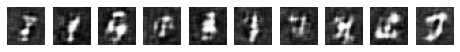

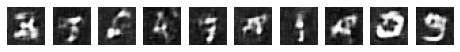

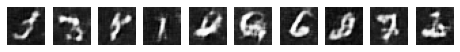

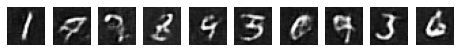

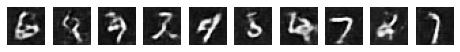

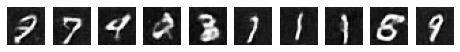

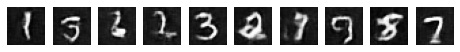

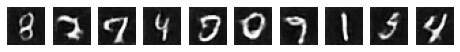

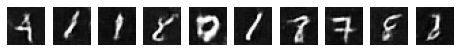

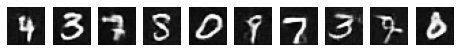

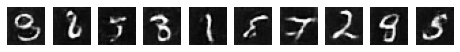

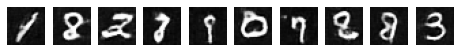

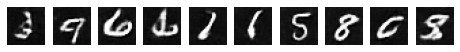

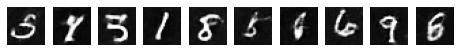

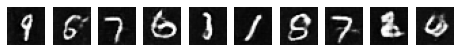

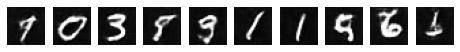

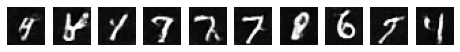

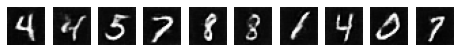

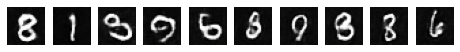

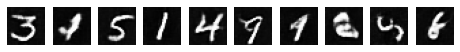

In [11]:
generator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)
discriminator_optimizer = tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5, beta_2=0.9)

def discriminator_loss(real_output, fake_output):
    real_loss = tf.reduce_mean(real_output)
    fake_loss = tf.reduce_mean(fake_output)
    return fake_loss - real_loss


def generator_loss(fake_output):
    return -tf.reduce_mean(fake_output)


epochs = 20

cbk = GANMonitor(num_img=10, latent_dim=noise_dim)

wgan = WGAN(
    discriminator=d_model,
    generator=g_model,
    latent_dim=noise_dim,
    discriminator_extra_steps=5,
)

wgan.compile(
    d_optimizer=discriminator_optimizer,
    g_optimizer=generator_optimizer,
    g_loss_fn=generator_loss,
    d_loss_fn=discriminator_loss,
)

wgan.fit(x_train, batch_size=BATCH_SIZE, epochs=epochs, callbacks=[cbk])